# 各種インポート

In [309]:
import pandas as pd
import time
from tqdm.notebook import tqdm_notebook as tqdm
import requests
from bs4 import BeautifulSoup
import re
import numpy as np

# Update関数

In [287]:
def update(func, update_id_list, old_data, merge=False):
    new_id_list = set(update_id_list) - (set(update_id_list) & set(old_data.index.unique().values))
    df = func(new_id_list)
    if merge:
        df = pd.concat([df, old_data])    
    return df

# レース結果取得

## 取得するレースのidを指定

In [4]:
race_id_list = []
for place in range(1,11,1):
    for kai in range(1,6,1):
        for day in range(1,9,1):
            for r in range(1,13,1):
                race_id = '2019' + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

年＋場所（01:札幌,02:函館,03:福島,04:新潟,05:東京,06:中山,07:中京,08:京都,09:阪神,10:小倉）＋回＋月日＋ラウンド

## スクレイピング

In [53]:
def scraping_race_result(id_list, pre_race_results={}):
    race_results = pre_race_results
    
    for race_id in tqdm(id_list):
        if race_id in pre_race_results.keys():
            continue
        try:
            url='https://db.netkeiba.com/race/' + race_id
            df = pd.read_html(url)[0]
            
            #horse_idとjockey_idを入れる
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')
            
            horse_id_list = []
            horse_a_list = soup.find('table',attrs={'summary':'レース結果'})\
                .find_all('a',attrs={'href':re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+', a['href'])
                horse_id_list.append(horse_id[0])
                
            jockey_id_list = []
            jockey_a_list = soup.find('table',attrs={'summary':'レース結果'})\
                .find_all('a',attrs={'href':re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+', a['href'])
                jockey_id_list.append(jockey_id[0])
                
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            
            race_results[race_id] = df
            
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return race_results

## 辞書型からDataFrame型に変換

In [57]:
def dict_to_pd(data):
    for key in data.keys():
        data[key].index = [key]*len(data[key])
    df = pd.concat([data[key] for key in data.keys()],sort=False)
    return df

## スクレイピング後のデータ

In [32]:
results = pd.read_pickle('results_2020.pickle')
results.head()

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師,horse_id,jockey_id
202106030811,1,4,7,エフフォーリア,牡3,57.0,横山武史,2:00.6,NaN,3.7,2.0,504(-10),[東] 鹿戸雄一,2018105027,01170
202106030811,2,7,13,タイトルホルダー,牡3,57.0,田辺裕信,2:01.1,3,17,8.0,462(-4),[東] 栗田徹,2018103559,01075
202106030811,3,2,3,ステラヴェローチェ,牡3,57.0,吉田隼人,2:01.1,クビ,14.3,6.0,500(0),[西] 須貝尚介,2018104980,01095
202106030811,4,1,1,アドマイヤハダル,牡3,57.0,ルメール,2:01.2,クビ,8.8,3.0,482(-2),[西] 大久保龍,2018105092,05339
202106030811,5,3,6,ヨーホーレイク,牡3,57.0,岩田望来,2:01.2,クビ,21.5,11.0,504(-2),[西] 友道康夫,2018105012,01174


# レース情報取得

## 実際に取得できたレースのid

In [33]:
results.index.unique()

Index(['202106030811', '202001010101', '202001010102', '202001010103',
       '202001010104', '202001010105', '202001010106', '202001010107',
       '202001010108', '202001010109',
       ...
       '202010020803', '202010020804', '202010020805', '202010020806',
       '202010020807', '202010020808', '202010020809', '202010020810',
       '202010020811', '202010020812'],
      dtype='object', length=3121)

## スクレイピング

In [9]:
def scrape_race_info(race_id_list):
    race_infos = {}
    
    for race_id in tqdm(race_id_list):
        try:
            url = 'https://db.netkeiba.com/race/' +race_id
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            texts = soup.find('div',attrs=['class','data_intro']).find_all('p')[0].text + \
                soup.find('div',attrs=['class','data_intro']).find_all('p')[1].text
            info = re.findall(r'\w+', texts)
            #infoに含まれるtextの内容によって項目を判断
            info_dict = {}
            for text in info:
                if text in ['芝','ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = re.findall(r'\d+',text)[0]
                if text in ['良','稍重','重','不良']:
                    info_dict['ground_state'] = text
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text
            race_infos[race_id] = info_dict
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return pd.DataFrame(race_infos).T

## スクレイピング後のデータ

In [27]:
race_infos = pd.read_pickle('race_infos.pickle')
race_infos.head()

,course_len,date,ground_state,race_type,weather
202106030811,2000,2021年4月18日,稍重,芝,晴
202001010101,1800,2020年7月25日,良,芝,曇
202001010102,1700,2020年7月25日,良,ダート,曇
202001010103,1500,2020年7月25日,良,芝,曇
202001010104,1700,2020年7月25日,良,ダート,曇


## レース結果にマージ

In [35]:
results_m = results.merge(race_infos, left_index=True, right_index=True, how='inner')

## 前処理

In [36]:
def preprocessing(race_result):
    df = race_result.copy()
    #着順から数字以外を含むデータを除く
    df = df[-df["着順"].astype(str).str.contains("\D")] 
    #性齢を性と齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)
    #馬体重を体重と体重増減に分ける
    df["体重"] = df["馬体重"].str.split('(',expand=True)[0].astype(int)
    df["体重増減"] = df["馬体重"].str.split('(',expand=True)[1].str[:-1].astype(int)
    #型変換と不要列削除
    df["単勝"] = df["単勝"].astype(float)
    df["着順"] = df["着順"].astype(int)
    df["人気"] = df["人気"].astype(int)
    df.drop(['性齢','馬体重','タイム','着差','調教師'], axis=1,inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
    df['course_len'] = df['course_len'].astype(int)
    
    return df

In [37]:
results_p = preprocessing(results_m)

## 前処理後のデータ

In [39]:
results_p.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,course_len,date,ground_state,race_type,weather,性,齢,体重,体重増減
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3,2018101626,01170,1800,2020-07-25,良,芝,曇,牝,2,438,4
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2,2018105193,05339,1800,2020-07-25,良,芝,曇,牡,2,510,0
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1,2018104800,01032,1800,2020-07-25,良,芝,曇,牡,2,482,-6
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4,2018102410,01176,1800,2020-07-25,良,芝,曇,牝,2,442,0
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5,2018100828,01116,1800,2020-07-25,良,芝,曇,牡,2,426,-8


# 馬ごとの過去成績を取得

## 取得する馬のidを指定

In [43]:
horse_id_list = results_p['horse_id'].unique()
len(horse_id_list)

11344

## スクレイピング

In [52]:
def scraping_horse_result(id_list, pre_horse_results={}):
    horse_results = pre_horse_results
    
    for horse_id in tqdm(id_list):
        if horse_id in horse_results.keys():
            continue
        try:
            url='https://db.netkeiba.com/horse/' + horse_id
            df = pd.read_html(url)[3]
            horse_results[horse_id] = df
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
    return horse_results

## データ更新時

In [53]:
horse_results_new = update(scraping_horse_result, horse_id_list, horse_results)

C:\Users\owner\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [58]:
horse_results_new = dict_to_pd(horse_results_new)

In [60]:
horse_results = pd.concat([horse_results_new, horse_results])

In [63]:
horse_results.to_pickle('horse_results.pickle')

## スクレイピング後のデータ

In [69]:
horse_results = pd.read_pickle('horse_results.pickle')
horse_results.index.nunique()

11389

In [175]:
horse_results.columns

Index(['日付', '開催', '天気', 'R', 'レース名', '映像', '頭数', '枠番', '馬番', 'オッズ', '人気',
       '着順', '騎手', '斤量', '距離', '馬場', '馬場指数', 'タイム', '着差', 'ﾀｲﾑ指数', '通過', 'ペース',
       '上り', '馬体重', '厩舎ｺﾒﾝﾄ', '備考', '勝ち馬(2着馬)', '賞金', '受賞歴'],
      dtype='object')

## HorseResultsクラス

In [178]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','R','賞金','開催','距離','タイム']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    def preprocessing(self):
        df = self.horse_results.copy()
        df = df[-df['R'].isnull()]
        df['賞金'] = df['賞金'].fillna(0).astype('int')
        df['日付'] = pd.to_datetime(df['日付'])
        df.rename(columns={'R':'着順'}, inplace=True)
        df['着順'] = df['着順'].astype('int')
        
#         #開催場所
#         place_dict = {'札幌':'01', '函館':'02', '福島':'03', '新潟':'04', '東京':'05', 
#                       '中山':'06', '中京':'07', '京都':'08', '阪神':'09','小倉':'10'}
#         df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
#         #距離
#         df['距離'] = df['距離'].str.extract(r'(\D+)')
#         #タイム
#         def to_second(x):
#             info = re.findall(r'(\d+)', str(x))
#             if len(info)==3:
#                 second = int(info[0]) * 60 + int(info[1])
#             else:
#                 second = 0        
#             return second
        
#         df['タイム'] = df['タイム'].map(lambda x : to_second(x))
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
#         target_df = self.horse_results.query('index in @horse_id_list')
        target_df = self.horse_results[self.horse_results.index.isin(horse_id_list)]
        #平均する対象をレース日付以前のうち直近n_samplesのデータのみに限定する（古いデータを反映させないため）
        if n_samples=='all':
            filtered_df = target_df[target_df['日付'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['日付'] < date].sort_values('日付', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        filtered_df = filtered_df.groupby(level=0)[['着順','賞金']].mean()
        filtered_df.rename(columns={'着順':'着順_{}R'.format(n_samples),'賞金':'賞金_{}R'.format(n_samples)}, inplace=True)
        return filtered_df
    
    def merge(self, results, date, n_samples):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        #レース結果の同じ日付のかたまりごとに1行ずつhorse_idにひもづくその日付以前の戦績の平均を算出し（average）、
        #レース結果のかたまりにマージする(merge)という意味
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)]) 
        return merged_df

## レース結果にマージ

In [72]:
hr = HorseResults(horse_results)
results_5R = hr.merge_all(results_p, n_samples=5)

## マージ後のデータ

In [73]:
results_5R.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,date,ground_state,race_type,weather,性,齢,体重,体重増減,着順_5R,賞金_5R
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3,2018101626,01170,...,2020-07-25,良,芝,曇,牝,2,438,4,6.0,0.0
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2,2018105193,05339,...,2020-07-25,良,芝,曇,牡,2,510,0,5.0,280.0
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1,2018104800,01032,...,2020-07-25,良,芝,曇,牡,2,482,-6,5.0,280.0
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4,2018102410,01176,...,2020-07-25,良,芝,曇,牝,2,442,0,5.0,70.0
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5,2018100828,01116,...,2020-07-25,良,芝,曇,牡,2,426,-8,5.0,0.0


# 払戻しデータを取得

In [87]:
from urllib.request import urlopen

def scraping_return_tables(id_list):
    return_tables = {}
    for race_id in tqdm(id_list):
        try:
            url='https://db.netkeiba.com/race/' + race_id
            f = urlopen(url)
            html = f.read()#バイト型の文字列
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)
            return_tables[race_id] = pd.concat([dfs[1], dfs[2]])
            time.sleep(0.1)
        except IndexError:
            continue
        except:
            break
            
    for key in return_tables.keys():
        return_tables[key].index = [key]*len(return_tables[key])
        
    return_tables_pd = pd.concat([return_tables[key] for key in return_tables.keys()],sort=False)
    return return_tables_pd

## スクレイピング後のデータ

In [146]:
return_tables = pd.read_pickle('return_tables.pickle')
return_tables.index.nunique()

3121

## 更新時

In [88]:
return_tables_new = update(scraping_return_tables, results.index.unique(), return_tables, merge=True)

In [92]:
return_tables_new.to_pickle('return_tables.pickle')

## Returnクラス

In [137]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    @property
    def tan(self):
        tan = self.return_tables[self.return_tables[0] == '単勝'][[1,2]]
        tan.columns = ['win', 'return']
        
        for column in tan.columns:
            tan[column] = pd.to_numeric(tan[column], errors='coerce')
        return tan
    
    @property
    def fuku(self):
        fuku = self.return_tables[self.return_tables[0] == '複勝'][[1,2]]
        #勝ち馬の馬番
        wins = fuku[1].str.split('br', expand = True).drop([3,4], axis=1)
        wins.columns = ['win_0', 'win_1', 'win_2']
        #払い戻し
        returns = fuku[2].str.split('br', expand = True).drop([3,4], axis=1)
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',','')
        return df.fillna(0).astype(int)
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == '馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand = True)[[0,1]].add_prefix('win_')
        returns = umaren[2].rename('return')
        
        df = pd.concat([wins, returns], axis=1)
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce')) #brを含むものをNaNにする

In [86]:
rt = Return.read_pickle(['return_tables.pickle'])

# 血統データ取得

## スクレイピング

In [282]:
def scraping_peds(id_list, pre_peds={}):
    peds = pre_peds
    
    for horse_id in tqdm(id_list):
        if horse_id in pre_peds.keys():
            continue
        try:
            url='https://db.netkeiba.com/horse/ped/' + horse_id
            df = pd.read_html(url)[0]
            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i] #若い世代から順に
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
                
            ped = pd.concat(generations[i] for i in range(5)).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
    return peds

## スクレイピング後のデータ

In [246]:
horse_id_list = horse_results.index.unique()
peds = scraping_peds(horse_id_list)

#データフレーム型に変換
peds = pd.concat([peds[horse_id] for horse_id in peds], axis=1).T
peds = peds.add_prefix('peds_')

11389

In [243]:
peds = Peds.read_pickle(['peds.pickle'])
peds = peds.peds
peds.head()

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018101626,ゴールドシップ 2009 芦毛 [血統][産駒] Halo系,コスモエルデスト 2011 鹿毛 [血統][産駒] FNo.[14-f],ステイゴールド 1994 黒鹿毛 [血統][産駒],ポイントフラッグ 1998 芦毛 [血統][産駒],ブラックホーク 1994 鹿毛 [血統][産駒],ビューティアイ 2005 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ゴールデンサッシュ 1988 栗毛 [血統][産駒],メジロマックイーン 1987 芦毛 [血統][産駒],パストラリズム 1987 黒鹿毛 [血統][産駒],...,Chieftain,Level Sands,Halo,Wishing Well,Carr de Naskra,Mawgrit,Danzig,Razyana,リアルシャダイ,マックスビューティ
2018105193,ディープインパクト 2002 鹿毛 [血統][産駒] Halo系,ヒストリックスター 2005 鹿毛 [血統][産駒] FNo.[9-f],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ベガ 1990 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Alzao 1980 鹿毛 [血統][産駒],Burghclere 1977 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Kalamoun,State Pension,Hornbeam,Priddy Fair,Nearctic,Natalma,Tom Fool,Brazen
2018104800,スクリーンヒーロー 2004 栗毛 [血統][産駒] Roberto系,マルバイユ Marbye(愛) 2000 鹿毛 [血統][産駒] FNo.[9-f],グラスワンダー 1995 栗毛 [血統][産駒],ランニングヒロイン 1993 鹿毛 [血統][産駒],Marju 1988 黒鹿毛 [血統][産駒],Hambye 1994 鹿毛 [血統][産駒],Silver Hawk 1979 鹿毛 [血統][産駒],Ameriflora 1989 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ダイナアクトレス 1983 鹿毛 [血統][産駒],...,Welsh Pageant,Electric Flash,Sir Gaylord,Little Hut,Claude,Ribasha,Thatch,Last Call,Mummy's Pet,Goosie-Gantlet
2018102410,キズナ 2010 青鹿毛 [血統][産駒] Halo系,ヴィアレッタ 2011 鹿毛 [血統][産駒] FNo.[14-c],ディープインパクト 2002 鹿毛 [血統][産駒],キャットクイル Catequil(加) 1990 鹿毛 [血統][産駒],Pivotal 1993 栗毛 [血統][産駒],ヴァレッタ Valletta(英) 2006 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ウインドインハーヘア Wind in Her Hair(愛) 1991 鹿毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Pacific Princess 1973 鹿毛 [血統][産駒],...,Bustino,Zerbinetta,Danzig,Foreign Courier,Ahonoora,Balidaress,Arctic Tern,Beaune,Nureyev,Unite
2018100828,リオンディーズ 2013 黒鹿毛 [血統][産駒] Mr. Prospector系,スマートエンデバー 2010 栗毛 [血統][産駒] FNo.[12-c],キングカメハメハ 2001 鹿毛 [血統][産駒],シーザリオ 2002 青毛 [血統][産駒],ファルブラヴ Falbrav(愛) 1998 鹿毛 [血統][産駒],ディスコホール 1989 栗毛 [血統][産駒],Kingmambo (米) 1990 鹿毛 [血統][産駒],マンファス Manfath(愛) 1991 黒鹿毛 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],キロフプリミエール Kirov Premiere(英) 1990 鹿毛 [血統][産駒],...,Lithiot,Nenana Road,Nearctic,Natalma,Victoria Park,Lady Angela,Herbager,Silver Sari,Crimson Satan,Bright Prospect


## Pedsクラス

In [326]:
from sklearn.preprocessing import LabelEncoder

class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_en = pd.DataFrame()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_en = df.astype('category')

## category型に変換

In [99]:
ped.encode()
peds = ped.peds_en
peds.head()

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018101626,253,2123,165,370,762,4026,96,168,230,372,...,56,333,63,370,72,485,87,821,1312,3114
2018105193,338,4804,154,237,749,4445,35,152,6,33,...,182,415,78,330,178,617,246,668,926,305
2018104800,289,5971,145,396,279,489,75,3,198,356,...,374,162,155,190,88,672,389,538,561,923
2018102410,224,7325,175,256,346,5456,96,162,156,191,...,51,645,35,106,9,50,19,89,606,2418
2018100828,446,3244,141,291,749,3521,46,189,203,319,...,182,415,109,230,451,417,153,930,204,315


## レース結果にマージ

In [100]:
results_ped = results_5R.merge(peds, left_on='horse_id', right_index=True, how='left')
results_ped.head()

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,horse_id,jockey_id,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202001010101,1,6,6,ウインルーア,54.0,横山武史,16.0,3,2018101626,01170,...,56,333,63,370,72,485,87,821,1312,3114
202001010101,2,2,2,アークライト,54.0,ルメール,1.9,2,2018105193,05339,...,182,415,78,330,178,617,246,668,926,305
202001010101,3,3,3,ギャラントウォリア,54.0,池添謙一,1.8,1,2018104800,01032,...,374,162,155,190,88,672,389,538,561,923
202001010101,4,1,1,ジュンブーケ,52.0,亀田温心,22.2,4,2018102410,01176,...,51,645,35,106,9,50,19,89,606,2418
202001010101,5,4,4,キタノマンゲツ,54.0,藤岡康太,55.7,5,2018100828,01116,...,182,415,109,230,451,417,153,930,204,315


In [103]:
results_ped.to_pickle('results_ped.pickle')

# 前処理

## 3着以内に入るかどうかを判定するrank列を追加し、不要な列を削除

In [105]:
results_ped["rank"] = results_ped["着順"].map(lambda x:1 if x <4 else 0)
results_ped.drop(["馬名","着順","騎手","単勝","人気"],axis=1, inplace=True)

In [107]:
results_ped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43255 entries, 202001010101 to 202106030811
Data columns (total 79 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   枠番            43255 non-null  int64         
 1   馬番            43255 non-null  int64         
 2   斤量            43255 non-null  float64       
 3   horse_id      43255 non-null  object        
 4   jockey_id     43255 non-null  object        
 5   course_len    43255 non-null  int32         
 6   date          43255 non-null  datetime64[ns]
 7   ground_state  43255 non-null  object        
 8   race_type     43255 non-null  object        
 9   weather       43255 non-null  object        
 10  性             43255 non-null  object        
 11  齢             43255 non-null  int32         
 12  体重            43255 non-null  int32         
 13  体重増減          43255 non-null  int32         
 14  着順_5R         38795 non-null  float64       
 15  賞金_5R         38795 non

## データをカテゴリ変数化、ダミー変数化

In [343]:
df = results_ped.copy()

target_columns = ['horse_id', 'jockey_id']

for column in target_columns:
    df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
    df[column] = df[column].astype('category')

#category型の列はダミー変数化しない
df_d = pd.get_dummies(df.select_dtypes(exclude='category'))
results_d = pd.concat([df_d, df.select_dtypes(include='category')], axis=1)

## 変換後のデータ

In [344]:
results_d.head()

,枠番,馬番,斤量,course_len,date,齢,体重,体重増減,着順_5R,賞金_5R,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202001010101,6,6,54.0,1800,2020-07-25,2,438,4,6.0,0.0,...,56,333,63,370,72,485,87,821,1312,3114
202001010101,2,2,54.0,1800,2020-07-25,2,510,0,5.0,280.0,...,182,415,78,330,178,617,246,668,926,305
202001010101,3,3,54.0,1800,2020-07-25,2,482,-6,5.0,280.0,...,374,162,155,190,88,672,389,538,561,923
202001010101,1,1,52.0,1800,2020-07-25,2,442,0,5.0,70.0,...,51,645,35,106,9,50,19,89,606,2418
202001010101,4,4,54.0,1800,2020-07-25,2,426,-8,5.0,0.0,...,182,415,109,230,451,417,153,930,204,315


In [345]:
results_d.to_pickle('results_d.pickle')

# モデル作成と結果検証

## パラメータチューニング

In [346]:
#データを分割する関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train =df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

In [347]:
#訓練データ、検証データ、テストデータに分割
train, test = split_data(results_d)
train, valid = split_data(train)

In [348]:
#それぞれ説明変数と被説明変数に分割
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

* 訓練データ→検証データの学習をパラメータを変えながら実行
* verbose_eval：何回の学習でパラメータを変えるか
* early_stopping_rounds：パラメータの種類（下記では10）を変更しても精度が上がらない場合学習を止める

In [351]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective':'binary', #2値予測の場合
    'random_state':100
}

lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid), 
                        verbose_eval=100, 
                        early_stopping_rounds=10)

[I 2021-06-24 22:28:57,834] A new study created in memory with name: no-name-44961e5f-8ade-4929-a34d-81c60960c425
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.417985	valid_1's binary_logloss: 0.494286


feature_fraction, val_score: 0.494286:  14%|######4                                      | 1/7 [00:03<00:18,  3.05s/it]

[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.491249:  29%|############8                                | 2/7 [00:04<00:12,  2.53s/it]

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.430235	valid_1's binary_logloss: 0.491249
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.491249:  43%|###################2                         | 3/7 [00:05<00:08,  2.19s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.438951	valid_1's binary_logloss: 0.492069
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.491249:  57%|#########################7                   | 4/7 [00:07<00:05,  1.91s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.426457	valid_1's binary_logloss: 0.493184
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.491249:  71%|################################1            | 5/7 [00:08<00:03,  1.74s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.425533	valid_1's binary_logloss: 0.491677
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.491249:  86%|######################################5      | 6/7 [00:09<00:01,  1.54s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.446549	valid_1's binary_logloss: 0.493628
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.44641	valid_1's binary_logloss: 0.49469
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:   5%|##5                                               | 1/20 [00:01<00:28,  1.51s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.379942	valid_1's binary_logloss: 0.493314
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  10%|#####                                             | 2/20 [00:02<00:24,  1.38s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.464912	valid_1's binary_logloss: 0.491286
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  15%|#######5                                          | 3/20 [00:04<00:25,  1.49s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.337726	valid_1's binary_logloss: 0.499141
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  20%|##########                                        | 4/20 [00:05<00:22,  1.40s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.443246	valid_1's binary_logloss: 0.493496
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  25%|############5                                     | 5/20 [00:07<00:21,  1.45s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.355522	valid_1's binary_logloss: 0.497346
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  30%|###############                                   | 6/20 [00:08<00:21,  1.50s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.349412	valid_1's binary_logloss: 0.497324
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  35%|#################5                                | 7/20 [00:09<00:18,  1.43s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.400834	valid_1's binary_logloss: 0.494018
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  40%|####################                              | 8/20 [00:11<00:17,  1.50s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.34143	valid_1's binary_logloss: 0.499033
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  45%|######################5                           | 9/20 [00:12<00:16,  1.45s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.40332	valid_1's binary_logloss: 0.493352
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  50%|########################5                        | 10/20 [00:14<00:14,  1.40s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.40292	valid_1's binary_logloss: 0.494382
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  55%|##########################9                      | 11/20 [00:15<00:13,  1.49s/it]

[100]	valid_0's binary_logloss: 0.471606	valid_1's binary_logloss: 0.492249
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.468242	valid_1's binary_logloss: 0.491861
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  60%|#############################4                   | 12/20 [00:16<00:10,  1.35s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.450916	valid_1's binary_logloss: 0.491498
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  65%|###############################8                 | 13/20 [00:18<00:09,  1.30s/it]

[100]	valid_0's binary_logloss: 0.471606	valid_1's binary_logloss: 0.492249
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.468242	valid_1's binary_logloss: 0.491861
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  70%|##################################3              | 14/20 [00:19<00:07,  1.26s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.425743	valid_1's binary_logloss: 0.493401
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  75%|####################################7            | 15/20 [00:20<00:06,  1.28s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.378822	valid_1's binary_logloss: 0.496258
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  80%|#######################################2         | 16/20 [00:21<00:04,  1.23s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.431977	valid_1's binary_logloss: 0.49289
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  85%|#########################################6       | 17/20 [00:23<00:03,  1.31s/it]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.370569	valid_1's binary_logloss: 0.495516
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  90%|############################################1    | 18/20 [00:24<00:02,  1.27s/it]

[100]	valid_0's binary_logloss: 0.477436	valid_1's binary_logloss: 0.494199
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.478265	valid_1's binary_logloss: 0.494196
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.491249:  95%|##############################################5  | 19/20 [00:25<00:01,  1.26s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.414182	valid_1's binary_logloss: 0.493063
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.396348	valid_1's binary_logloss: 0.496575
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  10%|#####3                                               | 1/10 [00:01<00:10,  1.22s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.433277	valid_1's binary_logloss: 0.493655
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  20%|##########6                                          | 2/10 [00:02<00:09,  1.19s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.440847	valid_1's binary_logloss: 0.493363
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  30%|###############9                                     | 3/10 [00:03<00:08,  1.15s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.437474	valid_1's binary_logloss: 0.495478
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  40%|#####################2                               | 4/10 [00:04<00:06,  1.11s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.445587	valid_1's binary_logloss: 0.497818
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  50%|##########################5                          | 5/10 [00:05<00:05,  1.09s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.437111	valid_1's binary_logloss: 0.496114
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  60%|###############################8                     | 6/10 [00:06<00:04,  1.08s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.446297	valid_1's binary_logloss: 0.497657
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  70%|#####################################                | 7/10 [00:07<00:03,  1.07s/it]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.443034	valid_1's binary_logloss: 0.494368
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  80%|##########################################4          | 8/10 [00:08<00:02,  1.06s/it]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.435271	valid_1's binary_logloss: 0.495465
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.491249:  90%|###############################################7     | 9/10 [00:09<00:01,  1.04s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.439255	valid_1's binary_logloss: 0.494468
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.491249:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.433372	valid_1's binary_logloss: 0.494535
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.490843:  17%|######3                               | 1/6 [00:01<00:05,  1.13s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428366	valid_1's binary_logloss: 0.490843
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.490843:  33%|############6                         | 2/6 [00:02<00:04,  1.11s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.440481	valid_1's binary_logloss: 0.49208
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.490843:  50%|###################                   | 3/6 [00:03<00:03,  1.14s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.421613	valid_1's binary_logloss: 0.492862
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.490843:  67%|#########################3            | 4/6 [00:04<00:02,  1.13s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.429249	valid_1's binary_logloss: 0.492685
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.490843:  83%|###############################6      | 5/6 [00:05<00:01,  1.15s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.425692	valid_1's binary_logloss: 0.492671
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:   0%|                                              | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428737	valid_1's binary_logloss: 0.491632
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:   5%|#9                                    | 1/20 [00:01<00:23,  1.26s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428373	valid_1's binary_logloss: 0.490843
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  10%|###8                                  | 2/20 [00:02<00:22,  1.25s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.427342	valid_1's binary_logloss: 0.491786
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  15%|#####7                                | 3/20 [00:03<00:21,  1.25s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.427464	valid_1's binary_logloss: 0.49113
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  20%|#######6                              | 4/20 [00:05<00:20,  1.26s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.426024	valid_1's binary_logloss: 0.492263
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  25%|#########5                            | 5/20 [00:06<00:18,  1.25s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428366	valid_1's binary_logloss: 0.490843
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  30%|###########4                          | 6/20 [00:07<00:17,  1.23s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.431453	valid_1's binary_logloss: 0.492238
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  35%|#############3                        | 7/20 [00:08<00:16,  1.23s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428367	valid_1's binary_logloss: 0.490843
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  40%|###############2                      | 8/20 [00:09<00:14,  1.23s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428366	valid_1's binary_logloss: 0.490843
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  45%|#################1                    | 9/20 [00:11<00:13,  1.22s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.431472	valid_1's binary_logloss: 0.492236
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  50%|##################5                  | 10/20 [00:12<00:12,  1.21s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428366	valid_1's binary_logloss: 0.490843
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490843:  55%|####################3                | 11/20 [00:13<00:11,  1.24s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.427214	valid_1's binary_logloss: 0.491306
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  60%|######################2              | 12/20 [00:14<00:10,  1.25s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.425948	valid_1's binary_logloss: 0.49001
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  65%|########################             | 13/20 [00:16<00:08,  1.25s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.439529	valid_1's binary_logloss: 0.492413
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  70%|#########################9           | 14/20 [00:17<00:07,  1.25s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.445422	valid_1's binary_logloss: 0.492238
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  75%|###########################7         | 15/20 [00:18<00:06,  1.29s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.434557	valid_1's binary_logloss: 0.491277
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  80%|#############################6       | 16/20 [00:20<00:05,  1.33s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.428008	valid_1's binary_logloss: 0.490699
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  85%|###############################4     | 17/20 [00:21<00:03,  1.32s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428726	valid_1's binary_logloss: 0.491189
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  90%|#################################3   | 18/20 [00:22<00:02,  1.33s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.425222	valid_1's binary_logloss: 0.490964
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.490010:  95%|###################################1 | 19/20 [00:24<00:01,  1.31s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.428375	valid_1's binary_logloss: 0.490842
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.490010:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.427325	valid_1's binary_logloss: 0.490966
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.490010:  20%|#########                                    | 1/5 [00:01<00:05,  1.30s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.43063	valid_1's binary_logloss: 0.49126
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.490010:  40%|##################                           | 2/5 [00:02<00:03,  1.31s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.424409	valid_1's binary_logloss: 0.492881
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.490010:  60%|###########################                  | 3/5 [00:03<00:02,  1.30s/it]

Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.429129	valid_1's binary_logloss: 0.491142
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.490010:  80%|####################################         | 4/5 [00:05<00:01,  1.26s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.43822	valid_1's binary_logloss: 0.491853
[LightGBM] [Info] Number of positive: 4593, number of negative: 16706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12024
[LightGBM] [Info] Number of data points in the train set: 21299, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215644 -> initscore=-1.291235
[LightGBM] [Info] Start training from score -1.291235
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.490010: 100%|#############################################| 5/5 [00:06<00:00,  1.28s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.430199	valid_1's binary_logloss: 0.490087


In [352]:
#最適化されたパラメータを確認
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.658465046145148,
 'lambda_l2': 0.0060537731975444506,
 'num_leaves': 31,
 'feature_fraction': 0.6479999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

## LightGBM

In [353]:
#被説明変数をrankにし、訓練データとテストデータに分割
train, test = split_data(results_d)
X_train = train.drop(['rank','date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank','date'], axis=1)
y_test = test['rank']

In [354]:
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score

params = {'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.658465046145148,
 'lambda_l2': 0.0060537731975444506,
 'num_leaves': 31,
 'feature_fraction': 0.6479999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values) 

C:\Users\owner\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.6479999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6479999999999999
[LightGBM] [Warning] lambda_l1 is set=1.658465046145148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.658465046145148
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0060537731975444506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0060537731975444506
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0,
               feature_fraction=0.6479999999999999, feature_pre_filter=False,
               lambda_l1=1.658465046145148, lambda_l2=0.0060537731975444506,
               num_iterations=1000, objective='binary', random_state=100)

## ModelEvaluatorクラス

In [128]:
from scipy.special import comb

class ModelEvaluator:
    def __init__(self, model, return_table, std=True):
        self.model = model
        self.tan = Return(return_table).tan
        self.fuku = Return(return_table).fuku
        self.umaren = Return(return_table).umaren
        self.std = std
        
    def predict_proba(self, X):
        proba = pd.Series(self.model.predict_proba(X)[:,1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x-x.mean())/x.std()
            proba = proba.groupby(level=0).transform(standard_scaler) #標準化
            proba = (proba - proba.min())/(proba.max() - proba.min()) #MinMaxスケーリング
        return proba
    
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1]['馬番']
        else:
            return pred_table
    
    def tan_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.tan.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
       
        money +=df[df['win']==df['馬番']]['return'].sum()
        return n_bets, money
            
    def fuku_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100*n_bets
        df = self.fuku.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money +=df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return n_bets, money
    
    def umaren_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds), 2) #レースごとに3着以内予想馬から2頭を選ぶ買い方の数
            hit[race_id] = set(self.umaren.loc[race_id][['win_0', 'win_1']]).issubset(set(preds)) #bool値が入る
        money = (self.umaren.index.map(hit).values * self.umaren['return']).sum()
        return n_bets, money
        

In [355]:
me = ModelEvaluator(lgb_clf, return_tables)

## 特徴量確認

In [356]:
me.feature_importance(X_test)

,features,importance
8,賞金_5R,1826
26,jockey_id,1379
7,着順_5R,1157
5,体重,963
1,馬番,807
25,horse_id,743
6,体重増減,732
28,peds_1,693
32,peds_5,682
86,peds_59,651


## 回収率計算

In [141]:
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5): 
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = min_threshold+ (1-min_threshold) * (i/n_samples) #threshold0.5から1までを100等分
        n_bets, money =return_func(X, threshold)
        if n_bets>lower:
            gain[n_bets] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [142]:
def gain2(return_func, X, n_samples=100, lower=50, min_threshold=0.5): 
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = min_threshold+ (1-min_threshold) * (i/n_samples) #threshold0.5から1までを100等分
        n_bets, money = return_func(X, threshold)
        if n_bets>lower:
            gain[threshold] = (n_bets*100+ money)/(n_bets*100)
    return pd.Series(gain)

In [357]:
tan = gain2(me.tan_return, X_test)
fuku = gain2(me.fuku_return, X_test)

In [359]:
umaren = gain2(me.umaren_return, X_test)

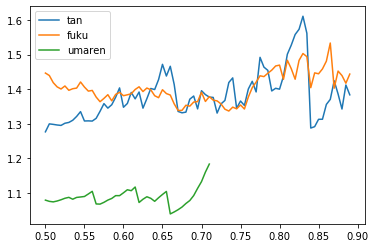

In [360]:
tan.rename('tan').plot(legend=True)
fuku.rename('fuku').plot(legend=True)
umaren.rename('umaren').plot(legend=True)

# 最新の出馬表を取得

In [106]:
# from selenium.webdriver import Chrome, ChromeOptions
# import chromedriver_binary

# class Entry_table:
#     def __init__(self):
#         self.entry_table = pd.DataFrame()
    
#     def scraping_table(self, race_id_list):
#         options = ChromeOptions()
#         driver = Chrome(options=options)
        
#         for race_id in race_id_list:
#             url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
#             driver.get(url)
#             elements = driver.find_elements_by_class_name('HorseList')
#             for element in elements:
#                 tds = element.find_elements_by_tag_name('td')
#                 row = []
#                 for td in tds:
#                     row.append(td.text)
#                     if td.get_attribute('class') in ['HorseInfo', 'Jockey']:
#                         href = td.find_element_by_tag_name('a').get_attribute('href')
#                         row.append(re.findall(r'\d+', href)[0])
#                 self.entry_table = self.entry_table.append(pd.Series(row, name = race_id))
            
#         driver.close()
        
#     def preprocessing(self):
#         df = self.entry_table.copy()
#         df = df[[0,1,3,4,5,6,7,8,10,11,12]]
#         self.entry_table = df
#         self.entry_table = self.entry_table.set_axis(['枠', '馬番','馬名','horse_id','性齢','斤量','騎手','jockey_id','馬体重','予想オッズ','人気'], axis=1)
        
#     def merge_horse_results(self, horse_results, columns, n_race=5):
#         for column in columns:
#             df = horse_results.groupby(level=0).head(n_race)
#             df = df.astype(str).groupby(level=0)[column].apply(lambda x: ','.join(x))
#             df = df.str.split(',', expand=True).add_prefix('{}_'.format(column))
#             self.entry_table = self.entry_table.merge(df, left_on='horse_id', right_index=True, how='left')

In [107]:
et = Entry_table()
et.scraping_table(['202105030609'])
et.preprocessing()
et.entry_table

,枠,馬番,馬名,horse_id,性齢,斤量,騎手,jockey_id,馬体重,予想オッズ,人気
202105030609,1,1,ベスビアナイト,2017105590,セ4,54.0,菅原明,01179,490(+2),6.7,5
202105030609,2,2,エドノフェリーチェ,2017104060,牝4,54.0,津村,01092,448(-4),5.1,3
202105030609,3,3,ライル,2016104868,セ5,55.0,石川,01150,490(-10),25.6,7
202105030609,4,4,アスティ,2016104998,セ5,54.0,江田照,00689,430(+4),49.4,9
202105030609,5,5,エカテリンブルク,2017105500,牡4,54.0,石橋脩,01077,510(+4),35.9,8
202105030609,6,6,ディスカバー,2014105545,セ7,53.0,原,01184,466(-2),201.3,11
202105030609,6,7,ドリームスピリット,2015102790,牡6,54.0,ルメール,05339,500(-2),6.5,4
202105030609,7,8,ヒルノダカール,2016100550,牡5,56.0,北村宏,01043,512(+4),11.1,6
202105030609,7,9,ペレ,2016104614,牝5,54.0,Ｍデムーロ,05212,456(-2),3.7,2
202105030609,8,10,レッドクーゲル,2016103041,牡5,53.0,吉田豊,00733,440(-4),80.7,10


## EntryTableクラス

In [319]:
class EntryTable:
    def __init__(self):
        self.entry_tables = pd.DataFrame()
        self.entry_tables_p = pd.DataFrame()
        self.entry_tables_hr = pd.DataFrame()
        self.entry_tables_ped = pd.DataFrame()
        self.entry_tables_cat = pd.DataFrame()
        
    def scraping(self, race_id_list, date):
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            #馬場情報などを取得
            texts = soup.find('div',attrs=['class','RaceData01']).text
            texts = re.findall(r'\w+', texts)

            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+',text)[0])]*len(df)
                if text in ['良','稍重','重']:
                    df['ground_state'] = [text]*len(df)
                if '不' in text:
                    df['ground_state'] = ['不良']*len(df)
                if '芝' in text:
                    df['race_type'] = ['芝']*len(df)
                if '障' in text:
                    df['race_type'] = ['障害']*len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート']*len(df)
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    df['weather'] = [text]*len(df)

            df['date'] = [date]*len(df)

            #horse_idとjockey_id取得
            horse_id_list = []
            horse_td_list = soup.find_all('td', attrs={'class':'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)

            jockey_id_list = []
            jockey_td_list = soup.find_all('td', attrs={'class':'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)

            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id]*len(df)
            self.entry_tables = self.entry_tables.append(df)

    def preprocessing(self):
        df = self.entry_tables.copy() 
        #性齢を性と齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)
        #馬体重を体重と体重増減に分ける
        df["体重"] = df["馬体重(増減)"].str.split('(',expand=True)[0].astype(int)
        df["体重増減"] = df["馬体重(増減)"].str.split('(',expand=True)[1].str[:-1].astype(int)
        
        df['date'] = pd.to_datetime(df['date'])
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        
        df = df[['枠', '馬番', '斤量', 'horse_id', 'jockey_id', 
                 'course_len', 'date', 'ground_state', 'race_type', 'weather', 
                 '性', '齢', '体重', '体重増減']]
        self.entry_tables_p = df.rename(columns={'枠':'枠番'})
        
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.entry_tables_hr = self.entry_tables_p.copy()
        for n_samples in n_samples_list:
            self.entry_tables_hr = hr.merge_all(self.entry_tables_hr, n_samples=n_samples)
            
    def merge_peds(self, peds):
        self.entry_tables_ped = self.entry_tables_hr.merge(peds, left_on='horse_id', right_index=True, how='left')
        
    def process_cat(self, le_horse, le_jockey, results):
        df = self.entry_tables_ped.copy()
        
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique() #過去レースデータにないhorse_idを特定
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id']) #0始まりの数字に変換
        
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique() #過去レースデータにないjockey_idを特定
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id']) #0始まりの数字に変換
        
        weathers = results['weather'].unique()
        race_type = results['race_type'].unique()
        ground_state = results['ground_state'].unique()
        sexes = results['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_type)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_state)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.entry_tables_cat = df

## 出馬表取得

In [320]:
et = EntryTable()
et.scraping(['202105030602'], '2021/06/20')

## 前処理

In [321]:
et.preprocessing()

## 馬ごとの過去成績をマージ

In [322]:
hr = HorseResults(horse_results)
et.merge_horse_results(hr)
# et.entry_tables_hr

## 血統データを更新して出馬表にマージ

In [224]:
#出馬する馬のリスト
update_id_list = et.entry_tables_ped['horse_id'].values
update_id_list

array(['2018100356', '2018106418', '2018103250', '2018105822',
       '2018105703', '2018101102', '2018105850', '2018105756',
       '2018105587', '2018100595', '2018103224', '2018105447',
       '2018104594', '2018103328'], dtype=object)

In [297]:
#出馬する馬のうち、取得済み血統データにない馬のみ血統データを取得
new_peds = update(scraping_peds, update_id_list, peds, merge=False)
new_peds

{'2018105447': 0     ノヴェリスト Novellist(愛) 2009 黒鹿毛 [血統][産駒] Blandford系
 1                  メモリアルサマー 1998 青毛 [血統][産駒] FNo.[9-f]
 2                             Monsun 1990 黒鹿毛 [血統][産駒]
 3                       Night Lagoon 2001 黒鹿毛 [血統][産駒]
 4        サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒]
                             ...                       
 57                                         Priddy Fair
 58                                            Ambiorix
 59                                            Striking
 60                                           Determine
 61                                       Fanciful Miss
 Name: 2018105447, Length: 62, dtype: object,
 '2018100356': 0     バトルプラン Battle Plan(米) 2005 鹿毛 [血統][産駒] Mr. Pro...
 1                   バクシンオージョ 2004 鹿毛 [血統][産駒] FNo.[1-w]
 2           エンパイアメーカー Empire Maker(米) 2000 黒鹿毛 [血統][産駒]
 3                             Flanders 1992 栗毛 [血統][産駒]
 4                              タイキシャトル 1994 栗毛 [血統][産駒]
                         

In [298]:
#取得した血統データを既に取得済みの血統データにマージ
new_peds = pd.concat([new_peds[horse_id] for horse_id in new_peds], axis=1).T
new_peds = new_peds.add_prefix('peds_')
new_peds

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2018105447,ノヴェリスト Novellist(愛) 2009 黒鹿毛 [血統][産駒] Blandford系,メモリアルサマー 1998 青毛 [血統][産駒] FNo.[9-f],Monsun 1990 黒鹿毛 [血統][産駒],Night Lagoon 2001 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],サマーワイン 1990 黒鹿毛 [血統][産駒],Konigsstuhl 1976 青毛 [血統][産駒],Mosella 1985 鹿毛 [血統][産駒],Lagunas 1981 黒鹿毛 [血統][産駒],Nenuphar 1994 黒鹿毛 [血統][産駒],...,Montparnasse,Edelweiss,Kalamoun,State Pension,Hornbeam,Priddy Fair,Ambiorix,Striking,Determine,Fanciful Miss
2018100356,バトルプラン Battle Plan(米) 2005 鹿毛 [血統][産駒] Mr. Pro...,バクシンオージョ 2004 鹿毛 [血統][産駒] FNo.[1-w],エンパイアメーカー Empire Maker(米) 2000 黒鹿毛 [血統][産駒],Flanders 1992 栗毛 [血統][産駒],タイキシャトル 1994 栗毛 [血統][産駒],ファゼンデイロ 1994 鹿毛 [血統][産駒],Unbridled 1987 鹿毛 [血統][産駒],Toussaud 1989 黒鹿毛 [血統][産駒],Seeking the Gold 1985 鹿毛 [血統][産駒],Starlet Storm 1987 栗毛 [血統][産駒],...,Thatch,Contrail,Red God,Runaway Bride,Roberto,Icy Blast,Never Bend,Hill Shade,Lyphard,Irish Star
2018105756,ジョーカプチーノ 2006 芦毛 [血統][産駒] Halo系,ヒカルウェイブ 2001 黒鹿毛 [血統][産駒] FNo.[3-n],マンハッタンカフェ 1998 青鹿毛 [血統][産駒],ジョープシケ 2000 芦毛 [血統][産駒],トニービン Tony Bin(愛) 1983 鹿毛 [血統][産駒],ブルーデキシー 1994 黒鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],サトルチェンジ Subtle Change(愛) 1988 黒鹿毛 [血統][産駒],フサイチコンコルド 1993 鹿毛 [血統][産駒],ジョーユーチャリス 1988 芦毛 [血統][産駒],...,Preciptic,Campanette,Princely Gift,Suncourt,ネヴァービート,スターハイネス,Nijinsky,シル,エンペリー,Some Progress
2018105850,ヘニーヒューズ Henny Hughes(米) 2003 [血統][産駒] Storm Bird系,メイショウスザンナ 2009 鹿毛 [血統][産駒] FNo.[4-j],ヘネシー Hennessy(米) 1993 栗毛 [血統][産駒],Meadow Flyer 1989 鹿毛 [血統][産駒],アグネスデジタル 1997 栗毛 [血統][産駒],グリーンオリーヴ 1997 鹿毛 [血統][産駒],Storm Cat (米) 1983 黒鹿毛 [血統][産駒],Island Kitty 1976 栗毛 [血統][産駒],Meadowlake 1983 栗毛 [血統][産駒],Shortley 1980 黒鹿毛 [血統][産駒],...,Alleged,Runaway Bride,Hail to Reason,Cosmah,Understanding,Mountain Flower,Nijinsky,シル,Sicambre,Fee Royale
2018100595,キンシャサノキセキ 2003 鹿毛 [血統][産駒] Halo系,メイショウシオギリ 2004 鹿毛 [血統][産駒] FNo.[1-d],フジキセキ 1992 青鹿毛 [血統][産駒],ケルトシャーン Keltshaan(米) 1994 鹿毛 [血統][産駒],メイショウドトウ 1996 鹿毛 [血統][産駒],メイショウエビータ 1995 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ミルレーサー Millracer(米) 1983 鹿毛 [血統][産駒],Pleasant Colony 1978 黒鹿毛 [血統][産駒],Featherhill 1978 鹿毛 [血統][産駒],...,Nijinsky,Fast Approach,Mr. Prospector,Mudville,Reflected Glory,Blue Eyed Blonde,Best Turn,Our Martha,Northern Dancer,Desert Flight
2018103328,ヤマニンセラフィム 1999 栗毛 [血統][産駒] Halo系,ヤマニンジャルダン 2003 鹿毛 [血統][産駒] FNo.[2],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ヤマニンパラダイス 1992 鹿毛 [血統][産駒],マイネルラヴ 1995 青鹿毛 [血統][産駒],ヤマニンカーニバル 1994 鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],Danzig 1977 鹿毛 [血統][産駒],Althea 1981 栗毛 [血統][産駒],...,Secretariat,Arachne,Ribot,Pocahontas,Bold Reasoning,Tomorrowland,Vice Regent,Miss Attractive,マルゼンスキー,パンクチェイシヨン
2018104594,ハーツクライ 2001 鹿毛 [血統][産駒] Halo系,クォリティシーズン 2008 黒鹿毛 [血統][産駒] FNo.[23-b],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],アイリッシュダンス 1990 鹿毛 [血統][産駒],トワイニング Twining(米) 1991 栗毛 [血統][産駒],コンファームドダンサー Confirmed Dancer(米) 1986 青鹿毛 [血統][産駒],Halo 1969 黒鹿毛 [血統][産駒],Wishing Well 1975 鹿毛 [血統][産駒],トニービン Tony Bin(愛) 1983 鹿毛 [血統][産駒],ビューパーダンス Buper Dance(米) 1983 黒鹿毛 [血統][産駒],...,War Admiral,Judy-Rae,Northern Dancer,Flaming Page,Val de Loir,Sly Pola,Never Bend,Roman Song,Cornish Prince,Won't Tell You


In [279]:
peds.index.nunique()

11389

In [299]:
new_peds1 = pd.concat([new_peds, peds])
new_peds1.index.nunique()

11396

In [327]:
#Pedsクラスに入れてcategory型に変換
p = Peds(new_peds1)
p.encode()
new_peds1 = p.peds_en

In [330]:
#出馬表にマージ
et.merge_peds(new_peds1)
et.entry_tables_ped

,枠番,馬番,斤量,horse_id,jockey_id,course_len,date,ground_state,race_type,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202105030602,1,1,52,2018100356,01164,1600,2021-06-20,不良,ダート,晴,...,336,122,132,298,346,367,249,432,504,1088
202105030602,2,2,54,2018106418,00689,1600,2021-06-20,不良,ダート,晴,...,209,135,22,214,265,107,84,46,115,1839
202105030602,3,3,54,2018103250,00684,1600,2021-06-20,不良,ダート,晴,...,121,630,62,61,444,526,488,1156,1200,2805
202105030602,3,4,54,2018105822,01162,1600,2021-06-20,不良,ダート,晴,...,121,630,62,61,444,526,46,954,403,341
202105030602,4,5,54,2018105703,01122,1600,2021-06-20,不良,ダート,晴,...,144,658,63,370,501,899,260,533,204,469
202105030602,4,6,54,2018101102,01127,1600,2021-06-20,不良,ダート,晴,...,189,399,114,254,339,455,492,1179,1090,2728
202105030602,5,7,54,2018105850,01154,1600,2021-06-20,不良,ダート,晴,...,6,515,62,61,444,526,253,1154,801,727
202105030602,5,8,54,2018105756,01118,1600,2021-06-20,不良,ダート,晴,...,254,85,124,334,509,927,253,1154,1052,2143
202105030602,6,9,54,2018105587,01158,1600,2021-06-20,不良,ダート,晴,...,75,367,124,334,509,927,260,533,164,1479
202105030602,6,10,54,2018100595,00733,1600,2021-06-20,不良,ダート,晴,...,225,183,101,223,331,100,32,712,601,559


In [329]:
le_horse = LabelEncoder().fit(results['horse_id'])
le_jockey = LabelEncoder().fit(results['jockey_id'])

In [331]:
et.process_cat(le_horse, le_jockey, results_p)
et.entry_tables_cat

,枠番,馬番,斤量,horse_id,jockey_id,course_len,date,齢,体重,体重増減,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_不良,ground_state_重,性_牝,性_牡,性_セ
202105030602,1,1,52,11389,114,1600,2021-06-20,3,474,0,...,0,1,0,0,0,1,0,1,0,0
202105030602,2,2,54,11044,8,1600,2021-06-20,3,454,2,...,0,1,0,0,0,1,0,1,0,0
202105030602,3,3,54,9523,7,1600,2021-06-20,3,472,-2,...,0,1,0,0,0,1,0,1,0,0
202105030602,3,4,54,10810,112,1600,2021-06-20,3,476,0,...,0,1,0,0,0,1,0,1,0,0
202105030602,4,5,54,10768,78,1600,2021-06-20,3,432,-6,...,0,1,0,0,0,1,0,1,0,0
202105030602,4,6,54,8623,83,1600,2021-06-20,3,452,-2,...,0,1,0,0,0,1,0,1,0,0
202105030602,5,7,54,11390,105,1600,2021-06-20,3,436,12,...,0,1,0,0,0,1,0,1,0,0
202105030602,5,8,54,11391,75,1600,2021-06-20,3,424,-6,...,0,1,0,0,0,1,0,1,0,0
202105030602,6,9,54,10716,108,1600,2021-06-20,3,446,4,...,0,1,0,0,0,1,0,1,0,0
202105030602,6,10,54,11392,14,1600,2021-06-20,3,466,-4,...,0,1,0,0,0,1,0,1,0,0


In [339]:
et.entry_tables_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 202105030602 to 202105030602
Data columns (total 94 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   枠番               14 non-null     int32         
 1   馬番               14 non-null     int32         
 2   斤量               14 non-null     int32         
 3   horse_id         14 non-null     int32         
 4   jockey_id        14 non-null     int32         
 5   course_len       14 non-null     int64         
 6   date             14 non-null     datetime64[ns]
 7   齢                14 non-null     int32         
 8   体重               14 non-null     int32         
 9   体重増減             14 non-null     int32         
 10  着順_5R            7 non-null      float64       
 11  賞金_5R            7 non-null      float64       
 12  着順_9R            7 non-null      float64       
 13  賞金_9R            7 non-null      float64       
 14  着順_allR          7 non-null 

## 予測

In [361]:
X_test = et.entry_tables_cat.drop(['date','着順_9R','賞金_9R','着順_allR','賞金_allR'], axis=1)

me.predict_proba(X_test)

202105030602    0.090427
202105030602    0.208541
202105030602    0.000962
202105030602    0.473869
202105030602    0.070881
202105030602    0.091505
202105030602    0.273849
202105030602    0.989310
202105030602    0.449469
202105030602    0.000000
202105030602    0.266361
202105030602    0.402870
202105030602    0.155700
202105030602    1.000000
dtype: float64